In [1]:
import numpy as np
from matplotlib import pyplot as plt

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import optax  # https://github.com/deepmind/optax
import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping

In [2]:
from nn import Module, Network

In [3]:
# Hyperparameters

BATCH_SIZE = 100
LEARNING_RATE = 1e-3
STEPS = 600
PRINT_EVERY = 30
SEED = 1234

In [4]:
normalise_data = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=True,
    download=True,
    transform=normalise_data,
)
test_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=False,
    download=True,
    transform=normalise_data,
)
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

In [5]:
layer1 = Module(
    eqx.nn.Linear(
        in_features=28*28,
        out_features=1024,
        key=jr.PRNGKey(SEED)
    )
)
layer2 = Module(
    eqx.nn.Linear(
        in_features=1024,
        out_features=500,
        key=jr.PRNGKey(SEED)
    )
)
layer3 = Module(
    eqx.nn.Linear(
        in_features=500,
        out_features=10,
        key=jr.PRNGKey(SEED)
    )
)

model = Network(
    [layer1, layer2],
    optax.adam(LEARNING_RATE)
)

print(model)

Network(
goodness: 0.0,
trainable layers: [0, 1],
optimizer: GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x7f687556a3e0>, update=<function chain.<locals>.update_fn at 0x7f687556b9c0>),
Layer 0: Module(
  _layer=Linear(
    weight=f32[1024,784],
    bias=f32[1024],
    in_features=784,
    out_features=1024,
    use_bias=True
  ),
  _activation=<function <lambda>>,
  _goodness_fn=<function <lambda>>,
  _opt_state=None,
  _theta=2.0
),
Layer 1: Module(
  _layer=Linear(
    weight=f32[500,1024],
    bias=f32[500],
    in_features=1024,
    out_features=500,
    use_bias=True
  ),
  _activation=<function <lambda>>,
  _goodness_fn=<function <lambda>>,
  _opt_state=None,
  _theta=2.0
),
)


In [6]:
dummy_x, dummy_y = next(iter(trainloader))
dummy_x = dummy_x.numpy()
dummy_y = dummy_y.numpy()
print(dummy_x.shape)  # BATCH_SIZEx1x28x28
print(dummy_y.shape)  # BATCH_SIZE

(100, 1, 28, 28)
(100,)


In [7]:
def overlay_y_on_x(x: Array, y: Array):
    """
    Replace the first 10 pixels of data [x] with one-hot-encoded label [y]
    """
    x_ = jnp.ravel(x)
    x_ = x_.at[:10].set(jax.nn.one_hot(y, 10))
    # x_ = x_.at[:10].set(jnp.zeros((10,)))
    # x_ = x_.at[y.item()].set(1)

    return x_.reshape(x.shape)

if BATCH_SIZE > 1:
    overlay_y_on_x = eqx.filter_vmap(overlay_y_on_x)

In [8]:
def permute_label(y: Array):
    return jax.random.permutation(jr.PRNGKey(SEED), y)

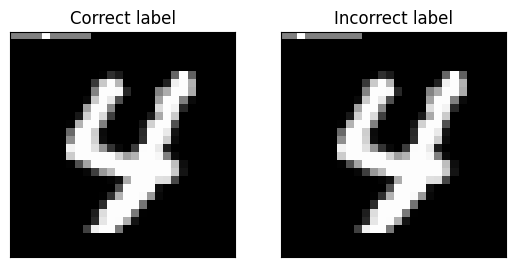

In [9]:
dummy_x_p = overlay_y_on_x(np.squeeze(dummy_x), dummy_y)
dummy_x_n = overlay_y_on_x(np.squeeze(dummy_x), permute_label(dummy_y))

if BATCH_SIZE > 1:
    show = (dummy_x_p[0], dummy_x_n[0])
else:
    show = (dummy_x_p, dummy_x_n)

ax = plt.subplot(1, 2, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(show[0], cmap='gray')
ax.set_title("Correct label")
ax = plt.subplot(1, 2, 2)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(show[1], cmap='gray')
ax.set_title("Incorrect label")
plt.show()

In [10]:
# train the first layer

losses = []
positive_gs = []
negative_gs = []

for i in range(STEPS):
    x, y = next(iter(trainloader))
    x = x.numpy()
    y = y.numpy()

    x_p = overlay_y_on_x(np.squeeze(x), y)
    x_n = overlay_y_on_x(np.squeeze(x), permute_label(y))

    if BATCH_SIZE > 1:
        x_p = jax.vmap(jnp.ravel)(x_p)
        x_n = jax.vmap(jnp.ravel)(x_n)

    loss, g_pos, g_neg = model.train_layer(
        0,
        x_p,
        x_n,
        batch = BATCH_SIZE > 1,
        batch_index=0
    )

    losses.append(loss)
    positive_gs.append(g_pos)
    negative_gs.append(g_neg)

    if i % PRINT_EVERY == 0:
        print(f"Step {i}: loss={loss:.4f}")

Step 0: loss=1.1269
Step 30: loss=1.1238
Step 60: loss=1.1127
Step 90: loss=1.0904
Step 120: loss=1.0565
Step 150: loss=1.0110
Step 180: loss=0.9579
Step 210: loss=0.9014
Step 240: loss=0.8511
Step 270: loss=0.7980
Step 300: loss=0.7608
Step 330: loss=0.7272
Step 360: loss=0.7093
Step 390: loss=0.7000
Step 420: loss=0.6952
Step 450: loss=0.6942
Step 480: loss=0.6933
Step 510: loss=0.6933
Step 540: loss=0.6932
Step 570: loss=0.6932


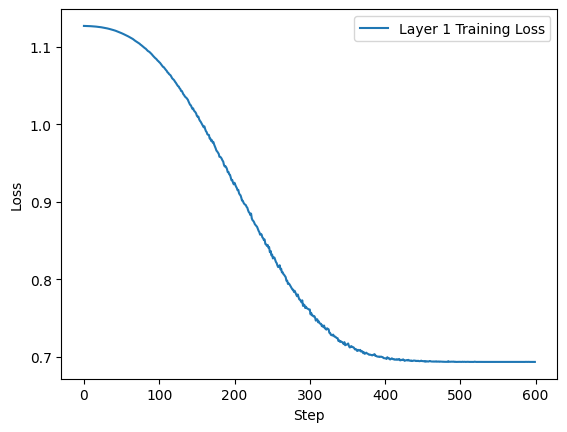

In [11]:
plt.plot(losses, label="Layer 1 Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
# train the second layer

losses_2 = []

for i in range(STEPS):
    x, y = next(iter(trainloader))
    x = x.numpy()
    y = y.numpy()

    x_p = overlay_y_on_x(np.squeeze(x), y)
    x_n = overlay_y_on_x(np.squeeze(x), permute_label(y))

    if BATCH_SIZE > 1:
        x_p = jax.vmap(jnp.ravel)(x_p)
        x_n = jax.vmap(jnp.ravel)(x_n)

    loss, g_pos, g_neg = model.train_layer(
        0,
        x_p,
        x_n,
        batch = BATCH_SIZE > 1,
        batch_index=0
    )

    losses_2.append(loss)

    if i % PRINT_EVERY == 0:
        print(f"Step {i}: loss={loss:.4f}")

Step 0: loss=0.6932
Step 30: loss=0.6932
Step 60: loss=0.6932
Step 90: loss=0.6931
Step 120: loss=0.6932
Step 150: loss=0.6933
Step 180: loss=0.6932
Step 210: loss=0.6932
Step 240: loss=0.6932
Step 270: loss=0.6932
Step 300: loss=0.6931
Step 330: loss=0.6932
Step 360: loss=0.6931
Step 390: loss=0.6932
Step 420: loss=0.6932
Step 450: loss=0.6931
Step 480: loss=0.6932
Step 510: loss=0.6931
Step 540: loss=0.6931
Step 570: loss=0.6932


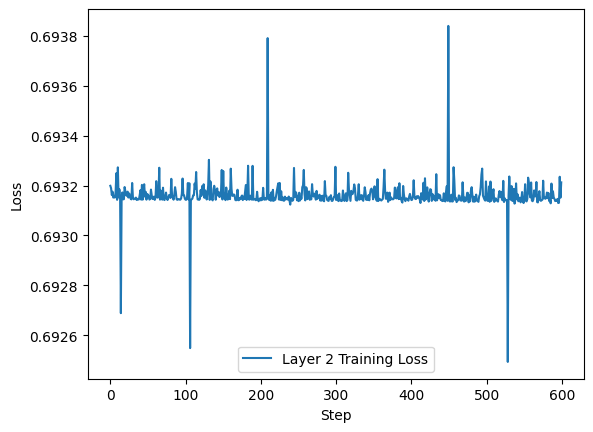

In [13]:
plt.plot(losses_2, label="Layer 2 Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
# Train the final layer

losses_3 = []

for i in range(STEPS):
    x, y = next(iter(trainloader))
    x = x.numpy()
    y = y.numpy()

    x_p = overlay_y_on_x(np.squeeze(x), y)
    x_n = overlay_y_on_x(np.squeeze(x), permute_label(y))

    if BATCH_SIZE > 1:
        x_p = jax.vmap(jnp.ravel)(x_p)
        x_n = jax.vmap(jnp.ravel)(x_n)

    loss, g_pos, g_neg = model.train_layer(
        0,
        x_p,
        x_n,
        batch = BATCH_SIZE > 1,
        batch_index=0
    )

    losses_3.append(loss)

    if i % PRINT_EVERY == 0:
        print(f"Step {i}: loss={loss:.4f}")

Step 0: loss=0.6931
Step 30: loss=0.6932
Step 60: loss=0.6931
Step 90: loss=0.6938
Step 120: loss=0.6931
Step 150: loss=0.6932
Step 180: loss=0.6931
Step 210: loss=0.6932
Step 240: loss=0.6931
Step 270: loss=0.6932
Step 300: loss=0.6931
Step 330: loss=0.6931
Step 360: loss=0.6933
Step 390: loss=0.6931
Step 420: loss=0.6932
Step 450: loss=0.6931
Step 480: loss=0.6932
Step 510: loss=0.6931
Step 540: loss=0.6931
Step 570: loss=0.6931


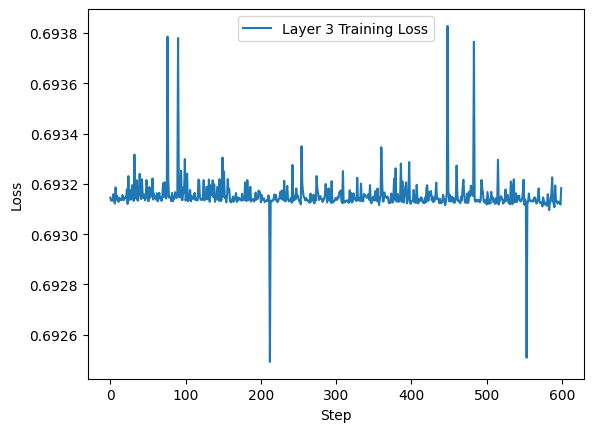

In [15]:
plt.plot(losses_3, label="Layer 3 Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
def predict(x: Array):
    goodness_per_label = []
    for label in range(10):
        x_ = overlay_y_on_x(x, np.array([label]))
        x_ = np.ravel(x_)
        x_ = np.expand_dims(x_, axis=0)
        goodness = 0.0
        for layer in model.layers:
            g = layer.goodness(x_)
            goodness += g
            x_ = layer.forward(x_)
        goodness_per_label.append(goodness.item())
    return np.argmax(goodness_per_label), goodness_per_label

In [17]:
prediction, goodnesses = predict(dummy_x[0])

print(f"Prediction: {prediction}")
print(f"Goodnesses: {goodnesses}")

Prediction: 1
Goodnesses: [69.91796112060547, 70.35189819335938, 70.0658950805664, 70.10843658447266, 70.18407440185547, 70.13848114013672, 70.1130599975586, 70.22132110595703, 70.09551239013672, 70.21109771728516]
